In [11]:
# reset notebook
%reset -f

In [1]:
# Import packages
import os
import shutil
import numpy as np
import scipy.constants
import matplotlib.pyplot as plt

In [21]:
scale_phonon_dos('180DW/with_dipole/original', 5)

In [6]:
# TODO: Integrate this with eos_fit.py
import numpy as np


def eosfitall(volume, energy, m, n):

    volume_range = np.linspace(np.min(volume), np.max(volume), 1000)
    volume_range = volume_range[:, np.newaxis]

    if m == 1:  # mBM: modified Birch-Murnaghan
        if n == 2:
            A1 = np.hstack((np.ones(volume.shape), volume**(-1 / 3)))
            A2 = np.hstack(
                (np.ones(volume_range.shape), volume_range**(-1 / 3)))
        elif n == 3:
            A1 = np.hstack((np.ones(volume.shape), volume **
                           (-1 / 3), volume**(-2 / 3)))
            A2 = np.hstack((np.ones(volume_range.shape),
                           volume_range**(-1 / 3), volume_range**(-2 / 3)))
        elif n == 4:
            A1 = np.hstack((np.ones(volume.shape), volume **
                           (-1 / 3), volume**(-2 / 3), volume**(-1)))
            A2 = np.hstack((np.ones(volume_range.shape), volume_range **
                           (-1 / 3), volume_range**(-2 / 3), volume_range**(-1)))
        elif n == 5:
            A1 = np.hstack((np.ones(volume.shape), volume**(-1 / 3),
                           volume**(-2 / 3), volume**(-1), volume**(-4 / 3)))
            A2 = np.hstack((np.ones(volume_range.shape), volume_range**(-1 / 3),
                           volume_range**(-2 / 3), volume_range**(-1), volume_range**(-4 / 3)))

    elif m == 2:  # BM: Birch-Murnaghan
        if n == 2:
            A1 = np.hstack((np.ones(volume.shape), volume**(-2 / 3)))
            A2 = np.hstack(
                (np.ones(volume_range.shape), volume_range**(-2 / 3)))
        elif n == 3:
            A1 = np.hstack((np.ones(volume.shape), volume **
                           (-2 / 3), volume**(-4 / 3)))
            A2 = np.hstack((np.ones(volume_range.shape),
                           volume_range**(-2 / 3), volume_range**(-4 / 3)))
        elif n == 4:
            A1 = np.hstack((np.ones(volume.shape), volume **
                           (-2 / 3), volume**(-4 / 3), volume**(-2)))
            A2 = np.hstack((np.ones(volume_range.shape), volume_range **
                           (-2 / 3), volume_range**(-4 / 3), volume_range**(-2)))
        elif n == 5:
            A1 = np.hstack((np.ones(volume.shape), volume**(-2 / 3),
                           volume**(-4 / 3), volume**(-2), volume**(-8 / 3)))
            A2 = np.hstack((np.ones(volume_range.shape), volume_range**(-2 / 3),
                           volume_range**(-4 / 3), volume_range**(-2), volume_range**(-8 / 3)))

    elif m == 3:  # LOG
        if n == 2:
            A1 = np.hstack((np.ones(volume.shape), np.log(volume)))
            A2 = np.hstack((np.ones(volume_range.shape), np.log(volume_range)))
        elif n == 3:
            A1 = np.hstack(
                (np.ones(volume.shape), np.log(volume), np.log(volume)**2))
            A2 = np.hstack((np.ones(volume_range.shape), np.log(
                volume_range), np.log(volume_range)**2))
        elif n == 4:
            A1 = np.hstack((np.ones(volume.shape), np.log(
                volume), np.log(volume)**2, np.log(volume)**3))
            A2 = np.hstack((np.ones(volume_range.shape), np.log(
                volume_range), np.log(volume_range)**2, np.log(volume_range)**3))
        elif n == 5:
            A1 = np.hstack((np.ones(volume.shape), np.log(volume), np.log(
                volume)**2, np.log(volume)**3, np.log(volume)**4))
            A2 = np.hstack((np.ones(volume_range.shape), np.log(volume_range), np.log(
                volume_range)**2, np.log(volume_range)**3, np.log(volume_range)**4))

    eos_parameters = np.linalg.pinv(A1).dot(energy)
    energy_fit = np.dot(A2, eos_parameters)

    return eos_parameters.T, energy_fit.T

In [8]:
def harmonic(path, T_range, num_atoms, eos_type, eos_rank):
    
    # Temperature range
    T = np.arange(T_range[0], T_range[1] + T_range[2], T_range[2]) # 1 row
    num_T = len(T)
    
    # Read the volumes
    file_list = os.listdir(path)
    volph_files = [file for file in file_list if 'volph' in file]
    for file in volph_files:
        volume = np.loadtxt(path + '/' + file)
        volume = volume.item()
        if 'volumes' in locals():
            volumes = np.append(volumes, volume)
        else:
            volumes = np.array([volume]) # 1 row
   
    # Constants
    k_B = scipy.constants.Boltzmann / scipy.constants.electron_volt  # The Boltzmann constant in eV/K
    h = scipy.constants.Planck / scipy.constants.electron_volt  # The Planck's constant in eVs
    
    # Read the scaled phonon DOS files from path
    vdos_files = [file for file in file_list if 'vdos' in file]
    for file in vdos_files:
        phonon_dos = np.loadtxt(path + '/' + file)
        
        # Extract frequency and dos from the scaled phonon DOS files
        frequency = phonon_dos[:, 0]  # Hz
        dos = phonon_dos[:, 1]  # 1/Hz
        
        # df, mid_f, and mid_dos are used to evaluate the integrals
        df = frequency[1:] - frequency[:-1]
        mid_f = (frequency[1:] + frequency[:-1]) * 0.5  # Use the middle value for the frequency in the integral
        mid_dos = (dos[1:] + dos[:-1]) * 0.5  # Use the middle value for the DOS in the integral
        
        # If abs(mid_f) < 1e-39, set it to 1e-39
        # TODO: review if this is necessary
        mid_f[np.abs(mid_f) < 1e-39] = 1e-39
        
        harmonic_properties = []
        # TODO: review below!
        # Calculate the harmonic properties using the phonon DOS at each volume over the temperature range
        for T in np.arange(T_range[0], T_range[1] + T_range[2], T_range[2]):
            constant = (h * mid_f) / (2 * k_B * T)

            A = df * mid_dos * np.log(2 * np.sinh(constant))
            free_energy = k_B * T * np.sum(A)  # eV/num_atoms

            A = df * mid_dos * (h * mid_f) * np.cosh(constant) / np.sinh(constant)
            internal_energy = 0.5 * np.sum(A)  # eV/num_atoms

            A = constant * np.cosh(constant) / np.sinh(constant) - np.log(2 * np.sinh(constant))
            entropy = k_B * np.sum(df * mid_dos * A)  # eV/K/num_atoms

            A = (1 / np.sinh(constant))**2
            cv = k_B * np.sum(df * mid_dos * constant**2 * A)  # eV/K/num_atoms

            harmonic_properties.append([T, free_energy, internal_energy, entropy, cv])
        
        # Convert list to numpy array
        harmonic_properties = np.vstack(harmonic_properties)
        
        # Collect the harmonic properties in a numpy array
        if 'free_energy_all' in locals():
            free_energy_all = np.hstack((free_energy_all, (harmonic_properties[:, 1] / num_atoms)[:, np.newaxis]))
        else:
            free_energy_all = (harmonic_properties[:, 1] / num_atoms)[:, np.newaxis]  # eV/atom
        
        if 'entropy_all' in locals():
            entropy_all = np.hstack((entropy_all, (harmonic_properties[:, 3] / num_atoms)[:, np.newaxis]))
        else:
            entropy_all = (harmonic_properties[:, 3] / num_atoms)[:, np.newaxis]  # eV/K/atom
            
        if 'cv_all' in locals():
            cv_all = np.hstack((cv_all, (harmonic_properties[:, 4] / num_atoms)[:, np.newaxis]))
        else:
            cv_all = (harmonic_properties[:, 4] / num_atoms)[:, np.newaxis]  # eV/K/atom
    
    # Fit the harmonic properties to an equation of state
    for i in range(num_T):
        free_energy_fit_append, y1_append = eosfitall(volumes[:, np.newaxis], free_energy_all[i, :][:, np.newaxis], eos_type, eos_rank)
        #print(y1_append)
        if i == 0:
            free_energy_fit = free_energy_fit_append
            y1 = y1_append
        else:
            free_energy_fit = np.vstack((free_energy_fit, free_energy_fit_append))
            y1 = np.vstack((y1, y1_append))

        entropy_fit_append, y2_append = eosfitall(volumes[:, np.newaxis], entropy_all[i, :][:, np.newaxis], eos_type, eos_rank)
        if i == 0:
            entropy_fit = entropy_fit_append
            y2 = y2_append
        else:
            entropy_fit = np.vstack((entropy_fit, entropy_fit_append))
            y2 = np.vstack((y2, y2_append))
            
        cv_append, y3_append = eosfitall(volumes[:, np.newaxis], cv_all[i, :][:, np.newaxis], eos_type, eos_rank)
        if i == 0:
            cv_fit = cv_append
            y3 = y3_append
        else:
            cv_fit = np.vstack((cv_fit, cv_append))
            y3 = np.vstack((y3, y3_append))
    
    volume_range = np.linspace(np.min(volumes), np.max(volumes), 1000)
            
    return T, free_energy_all, entropy_all, cv_all, volumes, free_energy_fit, entropy_fit, cv_fit, y1, y2, y3, volume_range
    # -> volume, down -> temperature
    # Each row is at a constant T
    # Each column is at a constant volume

In [48]:
# TESTING
def harmonic(path, T_range, num_atoms, eos_type, eos_rank):
    
    # Temperature range
    T_range = np.arange(T_range[0], T_range[1] + T_range[2], T_range[2]) # 1 row
    num_T = len(T_range)
    
    # Read the volumes
    file_list = os.listdir(path)
    volph_files = [file for file in file_list if 'volph' in file]
    for file in volph_files:
        volume = np.loadtxt(path + '/' + file)
        volume = volume.item()
        if 'volumes' in locals():
            volumes = np.append(volumes, volume)
        else:
            volumes = np.array([volume]) # 1 row
   
    # Constants
    k_B = scipy.constants.Boltzmann / scipy.constants.electron_volt  # The Boltzmann constant in eV/K
    h = scipy.constants.Planck / scipy.constants.electron_volt  # The Planck's constant in eVs
    
    # Read the scaled phonon DOS files from path
    vdos_files = [file for file in file_list if 'vdos' in file]
    for file in vdos_files:
        phonon_dos = np.loadtxt(path + '/' + file)
        
        # Extract frequency and dos from the scaled phonon DOS files
        frequency = phonon_dos[:, 0]  # Hz
        dos = phonon_dos[:, 1]  # 1/Hz
        
        # df, mid_f, and mid_dos are used to evaluate the integrals
        df = frequency[1:] - frequency[:-1]
        mid_f = (frequency[1:] + frequency[:-1]) * 0.5  # Use the middle value for the frequency in the integral
        mid_dos = (dos[1:] + dos[:-1]) * 0.5  # Use the middle value for the DOS in the integral
        
        # If abs(mid_f) < 1e-39, set it to 1e-39
        # TODO: review if this is necessary
        mid_f[np.abs(mid_f) < 1e-39] = 1e-39
        
        
        # TODO: Let's do it this way: Let's create an empty 2D array and fill it up
        harmonic_properties = []

        free_energy = np.empty((T_range.shape[0], volumes.shape[0]))
        internal_energy = np.empty((T_range.shape[0], volumes.shape[0]))
        entropy = np.empty((T_range.shape[0], volumes.shape[0]))
        cv = np.empty((T_range.shape[0], volumes.shape[0]))

        # TODO: review below!
        # Calculate the harmonic properties using the phonon DOS at each volume over the temperature range
        
        
        for T in T_range:
            constant = (h * mid_f) / (2 * k_B * T)

            A = df * mid_dos * np.log(2 * np.sinh(constant))
            free_energy_append = k_B * T * np.sum(A)  # eV/num_atoms

            A = df * mid_dos * (h * mid_f) * np.cosh(constant) / np.sinh(constant)
            internal_energy_append = 0.5 * np.sum(A)  # eV/num_atoms

            A = constant * np.cosh(constant) / np.sinh(constant) - np.log(2 * np.sinh(constant))
            entropy_append = k_B * np.sum(df * mid_dos * A)  # eV/K/num_atoms

            A = (1 / np.sinh(constant))**2
            cv_append = k_B * np.sum(df * mid_dos * constant**2 * A)  # eV/K/num_atoms

            harmonic_properties.append([T, free_energy_append, internal_energy_append, entropy_append, cv_append])
            
        # Convert list to numpy array
        harmonic_properties = np.vstack(harmonic_properties)
        
        # Fill in the values column by column
        #for j in range(array.shape[1]):
        #array[:, j] = np.arange(1, 6)  # Replace with your own values
        #print(array)

        # Collect the harmonic properties in a numpy array
        if 'free_energy_all' in locals():
            free_energy_all = np.hstack((free_energy_all, (harmonic_properties[:, 1] / num_atoms)[:, np.newaxis]))
        else:
            free_energy_all = (harmonic_properties[:, 1] / num_atoms)[:, np.newaxis]  # eV/atom
        
        if 'entropy_all' in locals():
            entropy_all = np.hstack((entropy_all, (harmonic_properties[:, 3] / num_atoms)[:, np.newaxis]))
        else:
            entropy_all = (harmonic_properties[:, 3] / num_atoms)[:, np.newaxis]  # eV/K/atom
            
        if 'cv_all' in locals():
            cv_all = np.hstack((cv_all, (harmonic_properties[:, 4] / num_atoms)[:, np.newaxis]))
        else:
            cv_all = (harmonic_properties[:, 4] / num_atoms)[:, np.newaxis]  # eV/K/atom
    
    # Fit the harmonic properties to an equation of state
    for i in range(num_T):
        free_energy_fit_append, y1_append = eosfitall(volumes[:, np.newaxis], free_energy_all[i, :][:, np.newaxis], eos_type, eos_rank)
        #print(y1_append)
        if i == 0:
            free_energy_fit = free_energy_fit_append
            y1 = y1_append
        else:
            free_energy_fit = np.vstack((free_energy_fit, free_energy_fit_append))
            y1 = np.vstack((y1, y1_append))

        entropy_fit_append, y2_append = eosfitall(volumes[:, np.newaxis], entropy_all[i, :][:, np.newaxis], eos_type, eos_rank)
        if i == 0:
            entropy_fit = entropy_fit_append
            y2 = y2_append
        else:
            entropy_fit = np.vstack((entropy_fit, entropy_fit_append))
            y2 = np.vstack((y2, y2_append))
            
        cv_append, y3_append = eosfitall(volumes[:, np.newaxis], cv_all[i, :][:, np.newaxis], eos_type, eos_rank)
        if i == 0:
            cv_fit = cv_append
            y3 = y3_append
        else:
            cv_fit = np.vstack((cv_fit, cv_append))
            y3 = np.vstack((y3, y3_append))
    
    volume_range = np.linspace(np.min(volumes), np.max(volumes), 1000)
            
    return T_range, free_energy_all, entropy_all, cv_all, volumes, free_energy_fit, entropy_fit, cv_fit, y1, y2, y3, volume_range, free_energy
    # -> volume, down -> temperature
    # Each row is at a constant T
    # Each column is at a constant volume

In [57]:
# Understand this first
import numpy as np

# Create an empty 2D array with 5 rows and 3 columns
array = np.empty((5, 3))

# Fill in the values column by column
for j in range(array.shape[1]):
    array[:, j] = np.arange(1, 6)  # Replace with your own values
print(array)

[[1. 1. 1.]
 [2. 2. 2.]
 [3. 3. 3.]
 [4. 4. 4.]
 [5. 5. 5.]]


In [50]:
[T, free_energy, entropy, cv, volumes, free_energy_fit, entropy_fit, cv_fit, y1, y2, y3, volume_range, test] = harmonic('MATLAB_FEG_with_dipole', [10, 1000, 10], 5, 2, 2)
print(free_energy)
#print(T.shape[0])
#print(volumes.shape[0])

#array = np.empty((T.shape[0], volumes.shape[0]))
#print(array)

[[ 5.85610295e-02  5.85066766e-02  5.85839978e-02  5.85014141e-02]
 [ 5.85429294e-02  5.84882213e-02  5.85648619e-02  5.84815831e-02]
 [ 5.84653469e-02  5.84103404e-02  5.84854564e-02  5.84007106e-02]
 [ 5.83035562e-02  5.82482468e-02  5.83211232e-02  5.82342414e-02]
 [ 5.80504467e-02  5.79943312e-02  5.80641409e-02  5.79742922e-02]
 [ 5.77039946e-02  5.76461715e-02  5.77119928e-02  5.76181810e-02]
 [ 5.72630351e-02  5.72024192e-02  5.72633348e-02  5.71645044e-02]
 [ 5.67265169e-02  5.66619965e-02  5.67171619e-02  5.66122888e-02]
 [ 5.60935529e-02  5.60240741e-02  5.60727478e-02  5.59608901e-02]
 [ 5.53635492e-02  5.52881540e-02  5.53297029e-02  5.52100214e-02]
 [ 5.45362772e-02  5.44541150e-02  5.44880091e-02  5.43597699e-02]
 [ 5.36118842e-02  5.35222118e-02  5.35480134e-02  5.34105824e-02]
 [ 5.25908671e-02  5.24930420e-02  5.25103946e-02  5.23632274e-02]
 [ 5.14740265e-02  5.13674979e-02  5.13761154e-02  5.12187472e-02]
 [ 5.02624152e-02  5.01467145e-02  5.01463708e-02  4.99784058e

In [17]:
# Gives the same answer as the MATLAB code
#free_energy_all, entropy_all, cv_all, volumes, free_energy_fit, entropy_fit, cv_fit, y1, y2, y3
[T, free_energy, entropy, cv, volumes, free_energy_fit, entropy_fit, cv_fit, y1, y2, y3, volume_range] = harmonic('MATLAB_FEG_with_dipole', [10, 1000, 10], 5, 2, 2)
print(free_energy)

[[ 5.85610295e-02  5.85066766e-02  5.85839978e-02  5.85014141e-02]
 [ 5.85429294e-02  5.84882213e-02  5.85648619e-02  5.84815831e-02]
 [ 5.84653469e-02  5.84103404e-02  5.84854564e-02  5.84007106e-02]
 [ 5.83035562e-02  5.82482468e-02  5.83211232e-02  5.82342414e-02]
 [ 5.80504467e-02  5.79943312e-02  5.80641409e-02  5.79742922e-02]
 [ 5.77039946e-02  5.76461715e-02  5.77119928e-02  5.76181810e-02]
 [ 5.72630351e-02  5.72024192e-02  5.72633348e-02  5.71645044e-02]
 [ 5.67265169e-02  5.66619965e-02  5.67171619e-02  5.66122888e-02]
 [ 5.60935529e-02  5.60240741e-02  5.60727478e-02  5.59608901e-02]
 [ 5.53635492e-02  5.52881540e-02  5.53297029e-02  5.52100214e-02]
 [ 5.45362772e-02  5.44541150e-02  5.44880091e-02  5.43597699e-02]
 [ 5.36118842e-02  5.35222118e-02  5.35480134e-02  5.34105824e-02]
 [ 5.25908671e-02  5.24930420e-02  5.25103946e-02  5.23632274e-02]
 [ 5.14740265e-02  5.13674979e-02  5.13761154e-02  5.12187472e-02]
 [ 5.02624152e-02  5.01467145e-02  5.01463708e-02  4.99784058e

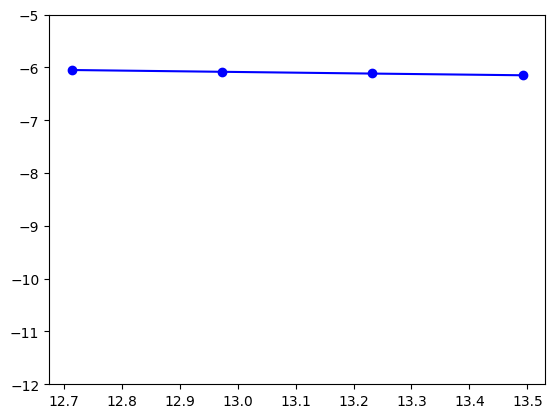

In [106]:

plt.plot(volumes, free_energy[69, :]*50, 'bo')
plt.ylim(-12, -5)
plt.plot(volume_range, y1[69, :]*50, 'b')
#print(volume_range)
#print(y1[0, :])

In [14]:
# Previous results
print(y_all)

[[ 0.05855354  0.05853555  0.05845833 ... -0.25757023 -0.26286026
  -0.26817578]
 [ 0.05855351  0.05853551  0.0584583  ... -0.25757322 -0.26286328
  -0.26817884]
 [ 0.05855348  0.05853548  0.05845826 ... -0.25757622 -0.26286631
  -0.26818189]
 ...
 [ 0.05852341  0.05850366  0.05842305 ... -0.26040822 -0.2657284
  -0.27107407]
 [ 0.05852338  0.05850363  0.05842302 ... -0.26041093 -0.26573114
  -0.27107684]
 [ 0.05852335  0.0585036   0.05842298 ... -0.26041364 -0.26573388
  -0.2710796 ]]


In [ ]:
# Clean up and document runelephonly!
# TODO: Clean up all of the variable names for harmonic